In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
#from nistats.first_level_model import FirstLevelModel
#from nistats.second_level_model import SecondLevelModel
#from nistats.thresholding import map_threshold
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl
from plotting_utils_ses_sstmsit_neuroimage import *

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

In [2]:
# def merge_pos_neg(pos, neg):
#     return image.math_img('pos-neg', pos=pos, neg=neg)

# def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=2.3,
#                           base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-msit'):
#     cope1 = first_level_copes[first_level_contrast]
#     cope2 = second_level_copes[second_level_contrast]

#     if thresholding is None:
#         nii = nib.load(os.path.join(base_dir, 'third_level_model',  'level3_zstats', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'zstat{cope2}.nii.gz'))
#         threshold = 0
#     elif thresholding == 'fwer' or thresholding == 'cluster':
#         nii_pos = os.path.join(base_dir, 'grf_thresholded_zstats_file', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'_threshold_{threshold_z}', f'_grf_cluster{cope2-1}', 'zstat1_threshold.nii.gz')
#         nii_neg = os.path.join(base_dir, 'grf_thresholded_zstats_file', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'_threshold_{threshold_z}', f'_grf_cluster{cope2}', f'zstat{cope2+1}_threshold.nii.gz') #os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(neg_contrast)
#         nii = merge_pos_neg(nii_pos, nii_neg)
#         threshold = np.min(nib.load(nii_pos).get_fdata())
# #     elif thresholding == 'fwer1':
# #         # single side only
# #         nii = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(cope2)
# #         threshold = np.min(nib.load(nii).get_fdata())
        
#     elif thresholding == 'fdr':
#         # if threshold returns as inf it means that no significance was found
#         nii = nib.load(os.path.join(base_dir, 'third_level_model', 'level3_zstats', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'zstat{cope2}.nii.gz'))
#         print(os.path.join(base_dir, 'third_level_model', 'level3_zstats', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'zstat{cope2}.nii.gz'))
#         _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')

#     return nii, threshold

# def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
#     cols = rows = int(np.sqrt(n_cuts))
    
#     gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1.25]) # 4th column wider so that coloubar doesnt shrink image
#     f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
#     ax = axes.ravel()
    
#     cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
#     if(z_map.get_fdata().sum() == 0):
#         print('No non-zero z-values, nothing to plot!')
#         return f, ax
    
#     for i in range(n_cuts):
#         # plot colorbar in right-most column
#         if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
#             colorbar = True
#         else:
#             colorbar = False
        
#         if i == 0 and 'title' in kwargs.keys():
#             title = kwargs.pop('title')
#         else:
#             title = None
        
#         plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
#                                cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
#     f.set_size_inches(15,15)
#     return f, ax

In [4]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-msit',
                          from_working_dir=False, 
                          flame='1'):
    
    if model_n == 0: 
        first_level_copes = {'con': 0,
                         'simon': 1,
                         'flanker': 2,
                         'inc': 3,
                         'simon-con': 4,
                         'flanker-con': 5,
                         'inc-con': 6,
                         'simon-flanker': 7,
                         'inc-simon': 8,
                         'inc-flanker': 9#,
                         #'timing_feedback': 10
                         }
    elif model_n == 1:
        first_level_copes = {'response_index': 0,
                             'response_middle': 1,
                             'responce_ring':2,
                             'response_index-response_middle':3,
                             'response_index-response_ring':4,
                             'response_middle-response_ring':5
                            }
    elif model_n == 2:
        first_level_copes = {'correct':0,
                             'incorrect':1,
                             'incorrect-correct':2
                            }

    second_level_copes = {'intercept': 1,
                          '-intercept': 2}
    
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_sstmsit_hp/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

# Individual Contrasts

### motor stuff

In [ ]:
z_map_intercept, threshold = get_second_level_zmap('response_index', 'intercept', thresholding='fdr',model_n=1,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Index (intercept)')

z_map_intercept, threshold = get_second_level_zmap('response_middle', 'intercept', thresholding='fdr',model_n=1,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Middle (intercept)')

z_map_intercept, threshold = get_second_level_zmap('response_ring', 'intercept', thresholding='fdr',model_n=1,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Ring (intercept)')

### incorrect / correct responses stuff

In [ ]:
z_map_intercept, threshold = get_second_level_zmap('correct', 'intercept', thresholding='fdr',model_n=2,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Correct (intercept)')

z_map_intercept, threshold = get_second_level_zmap('incorrect', 'intercept', thresholding='fdr',model_n=2,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Incorrect (intercept)')

z_map_intercept, threshold = get_second_level_zmap('incorrect-correct', 'intercept', thresholding='fdr',model_n=2,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Incorrect - Correct (intercept)')

## Congruent

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


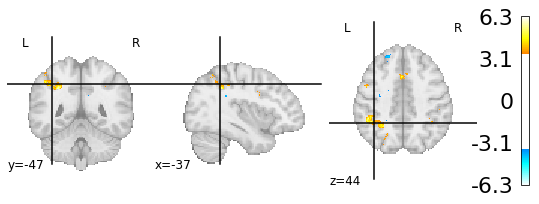

In [23]:
plotting.plot_stat_map(z_map_intercept, threshold=threshold)

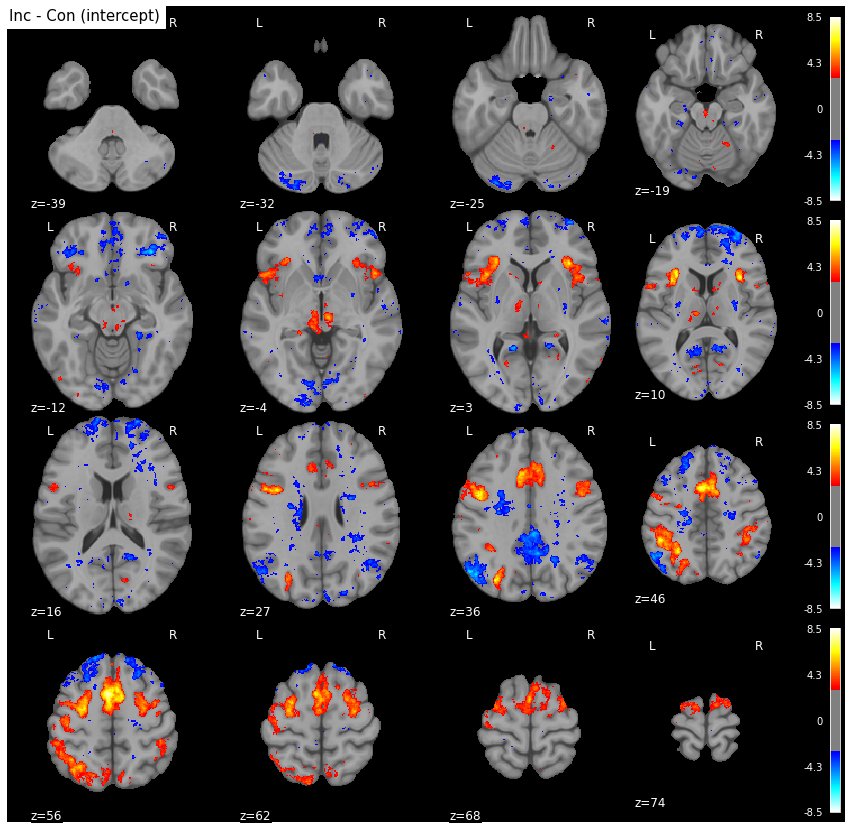

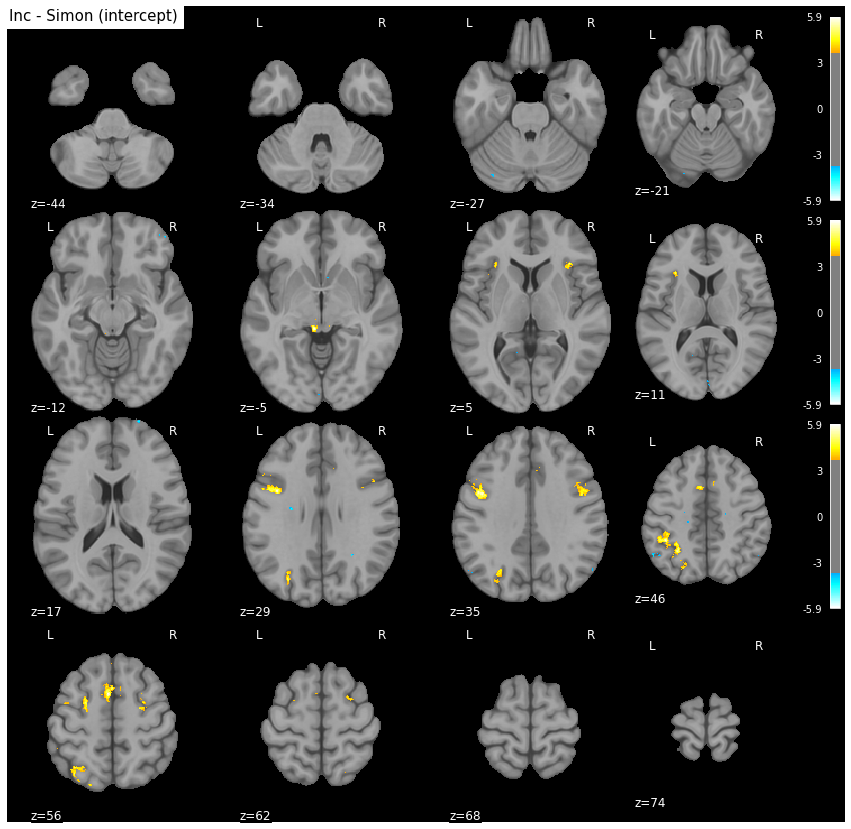

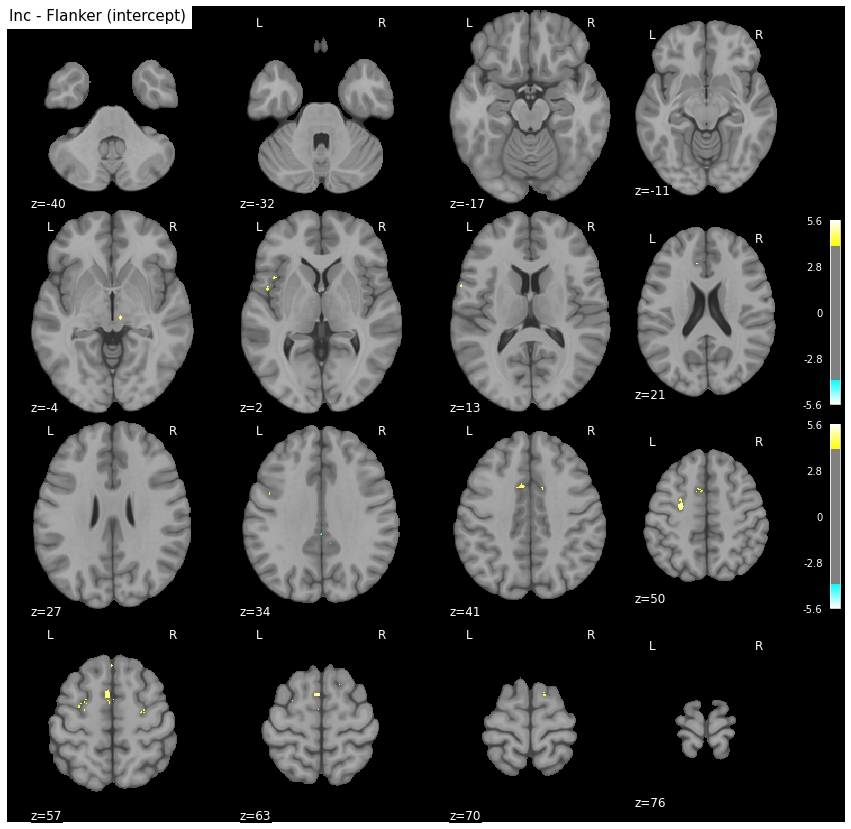

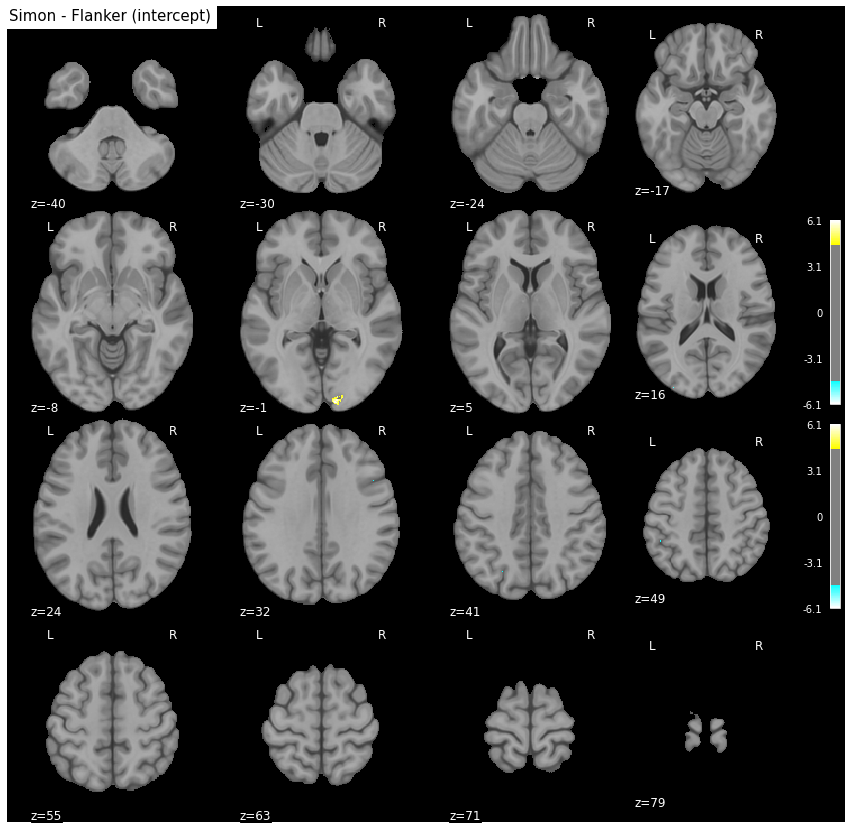

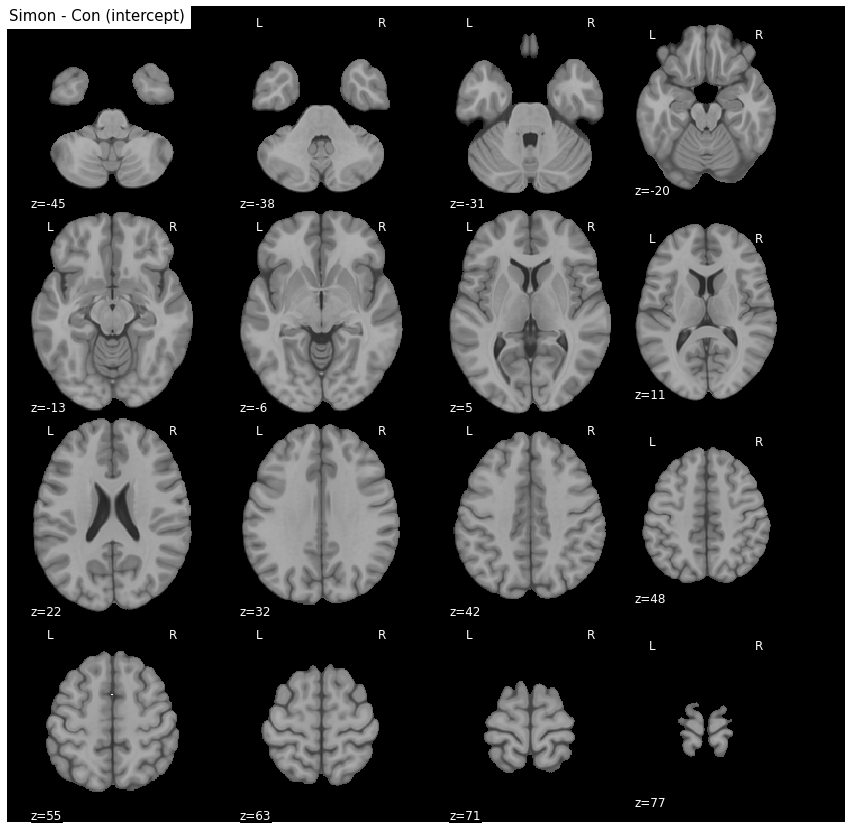

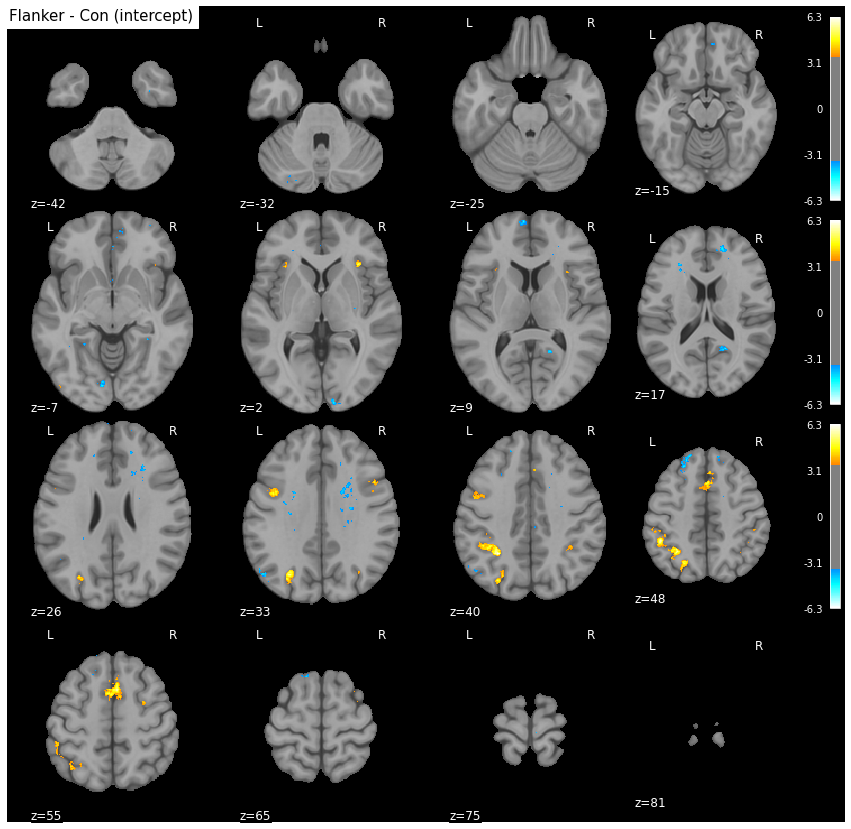

In [4]:
z_map_intercept, threshold = get_second_level_zmap('inc-con', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Inc - Con (intercept)')

z_map_intercept, threshold = get_second_level_zmap('inc-simon', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Inc - Simon (intercept)')

z_map_intercept, threshold = get_second_level_zmap('inc-flanker', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Inc - Flanker (intercept)')

z_map_intercept, threshold = get_second_level_zmap('simon-flanker', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Simon - Flanker (intercept)')

z_map_intercept, threshold = get_second_level_zmap('simon-con', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Simon - Con (intercept)')

z_map_intercept, threshold = get_second_level_zmap('flanker-con', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_intercept, threshold=threshold, bg_img=mni09c, title='Flanker - Con (intercept)')

# PLot a lil differently

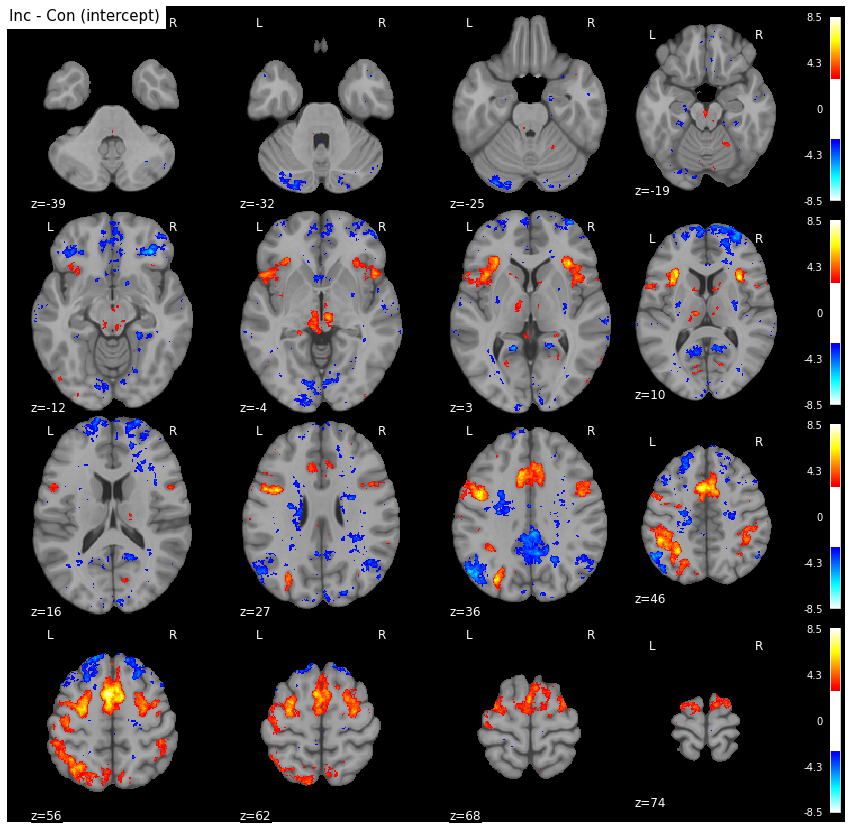

In [4]:
z_map_responselr_intercept, threshold = get_second_level_zmap('inc-con', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, bg_img=mni09c, title='Inc - Con (intercept)')

In [5]:
# Load MNI template
# Make background colour black
mni09c_load = nib.load(mni09c)
black_bg = mni09c_load.get_data()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=mni09c_load.affine)

thresh_method = 'fdr' # 'cluster'
fwhm = '1p5'

zmap_inccon, thresh1 = get_second_level_zmap('inc-con', 'intercept', fwhm=fwhm, thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh1)
zmap_simoncon, thresh2 = get_second_level_zmap('simon-con', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh2)
zmap_flankercon, thresh3 = get_second_level_zmap('flanker-con', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh3)
zmap_incflanker, thresh4 = get_second_level_zmap('inc-flanker', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh4)
zmap_incsimon, thresh5 = get_second_level_zmap('inc-simon', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh5)
zmap_simonflanker, thresh6 = get_second_level_zmap('simon-flanker', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh6)

# zmaps = [zmap_inccon, zmap_simoncon, zmap_flankercon]
zmaps = [zmap_inccon, zmap_simoncon, zmap_flankercon, zmap_incflanker, zmap_incsimon, zmap_simonflanker]
thresh = [thresh1, thresh2, thresh3, thresh4, thresh5, thresh6]

# zmaps = []

/tmp/ipykernel_3050482/364536245.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  black_bg = mni09c_load.get_data()


2.864088773726417
5.251828670500709
3.5862212181081308
4.141837120055152
3.665409803389503
4.537656307219459


In [6]:
zmaps[:5]

In [7]:
these_maps = zmaps[:5]
these_thresh = thresh[:5]

/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


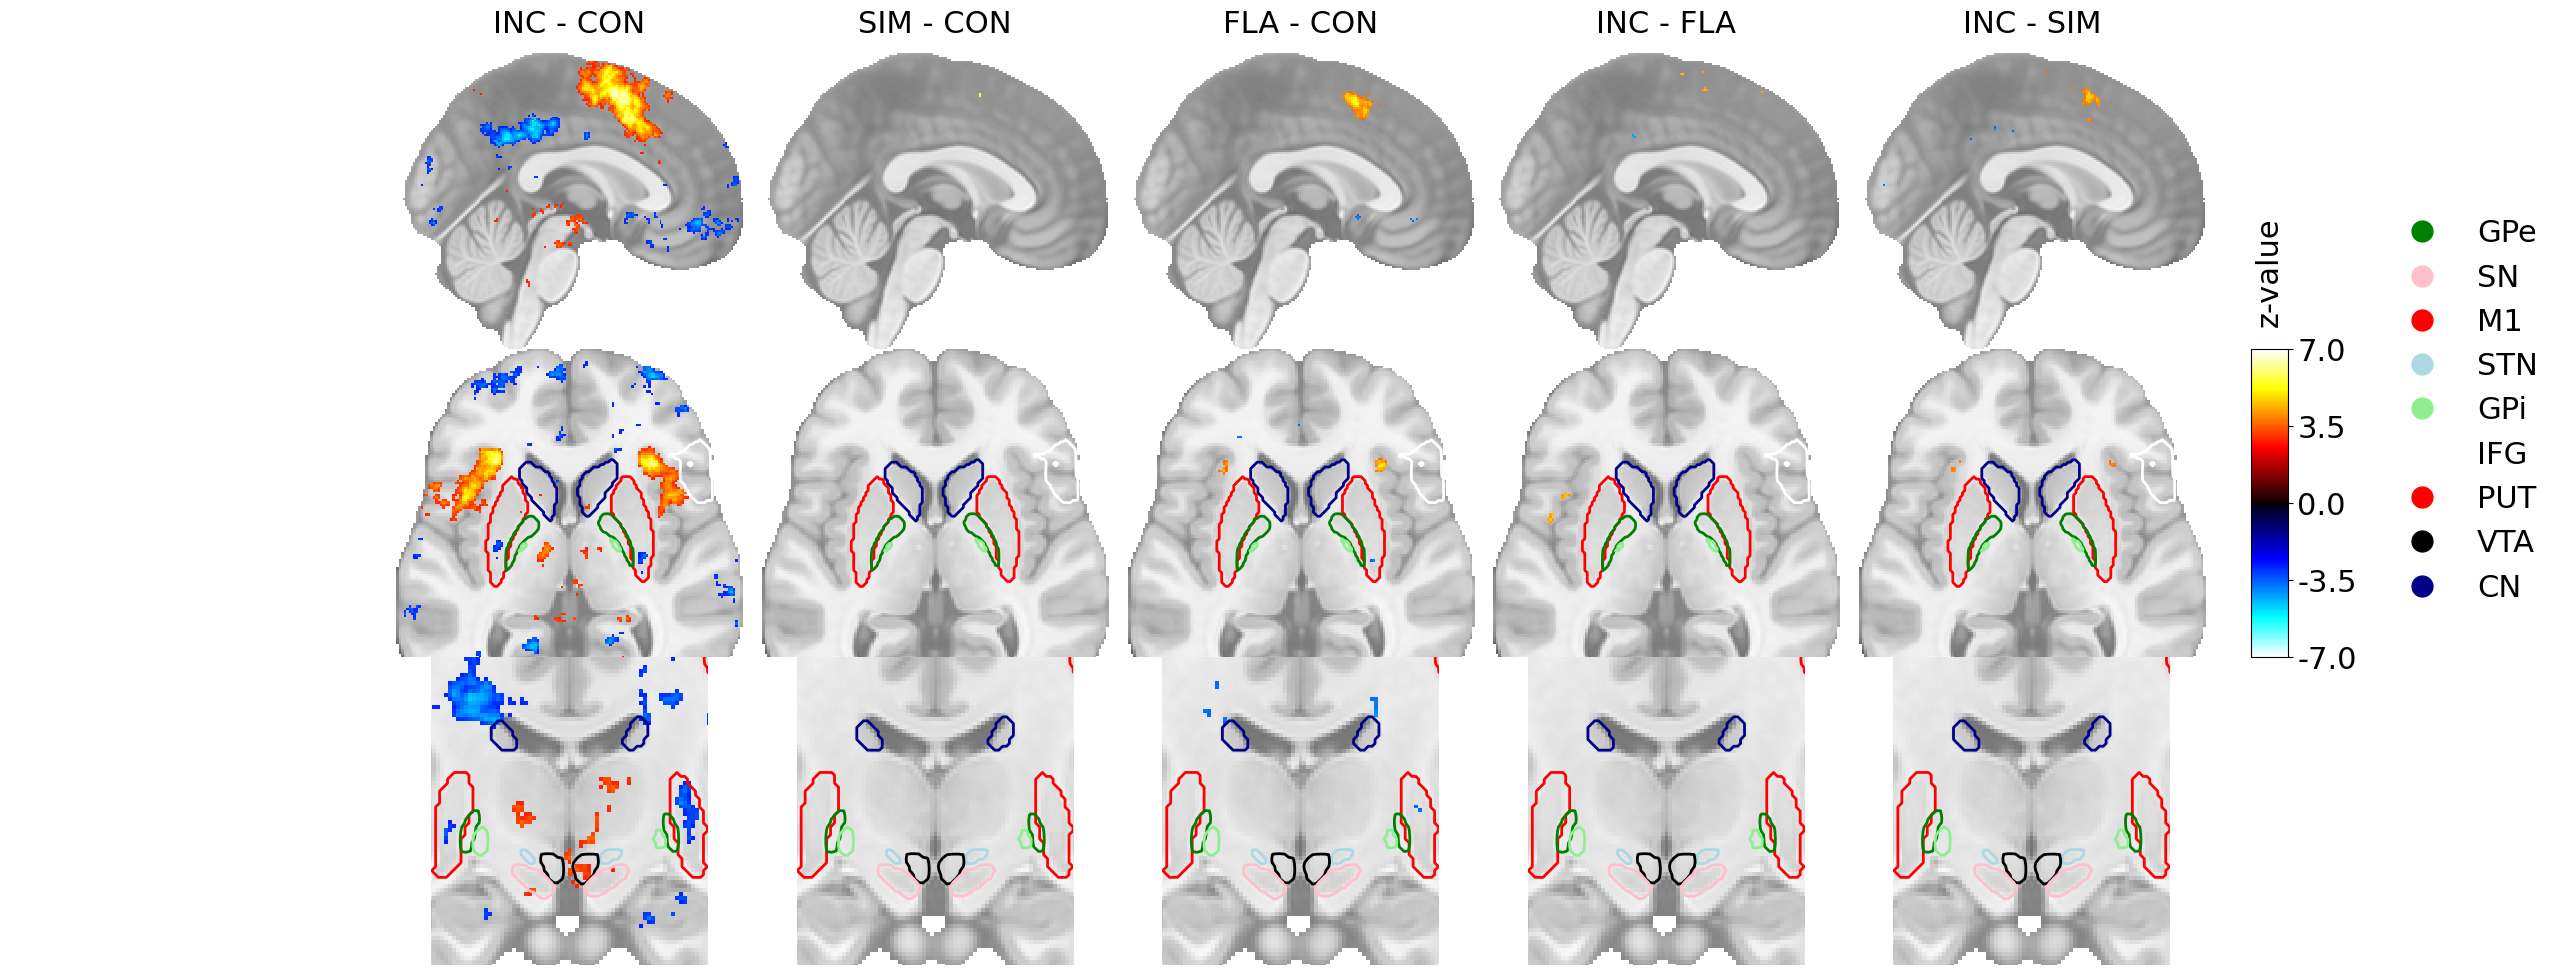

In [8]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(these_maps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(these_maps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(these_maps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(these_maps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=these_thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'], #'AV'
                          cut_coords=[[0], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2,3,4),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('INC - CON')
axes[0,1].set_title('SIM - CON')
axes[0,2].set_title('FLA - CON')
axes[0,3].set_title('INC - FLA')
axes[0,4].set_title('INC - SIM')
# axes[0,5].set_title('SIM - FLA')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

Text(0.5, 1.0, 'z-value')

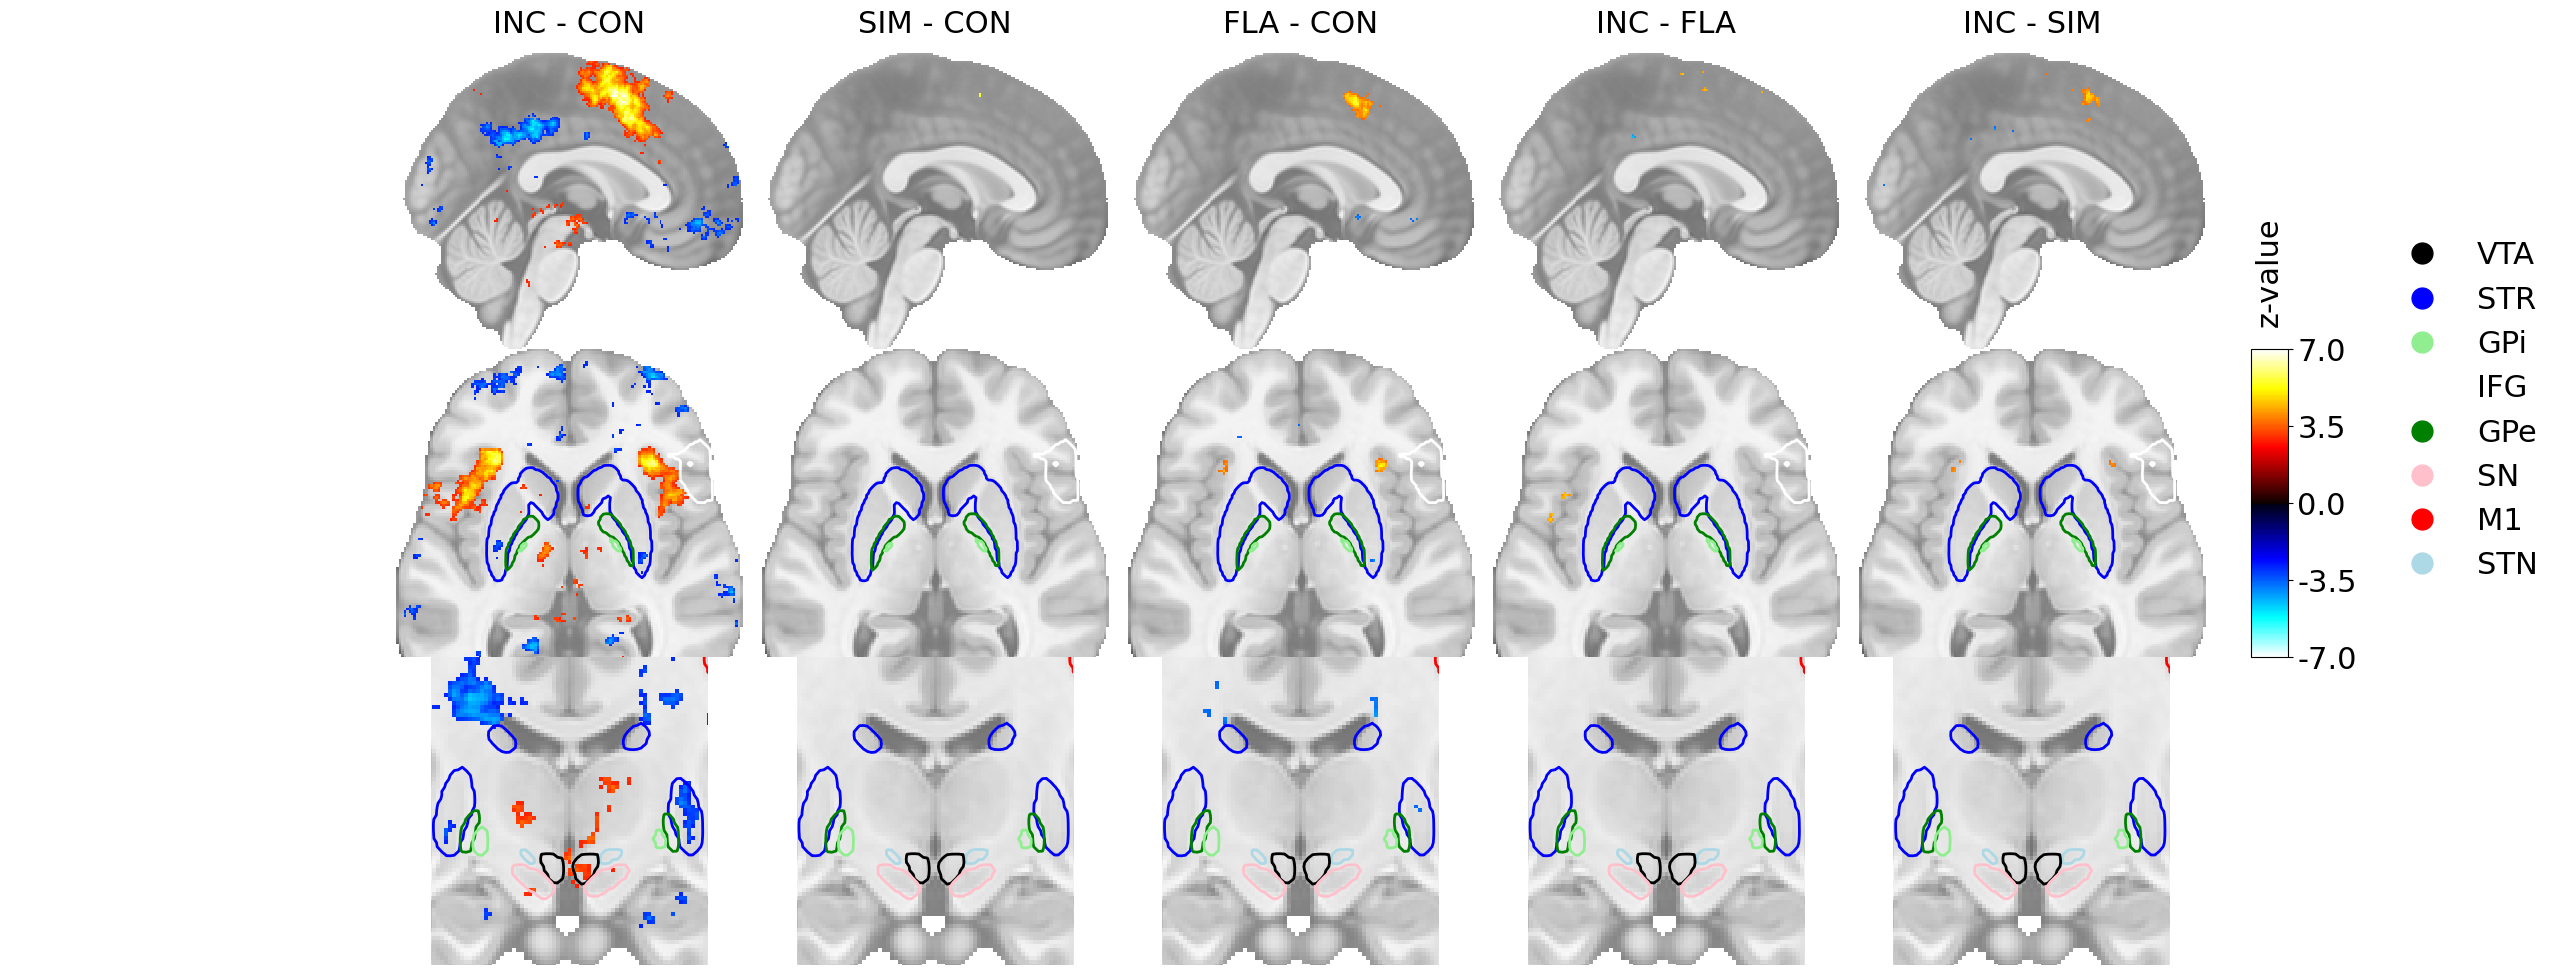

In [24]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(these_maps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(these_maps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(these_maps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(these_maps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=these_thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'], #'AV'
                          cut_coords=[[0], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2,3,4),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('INC - CON')
axes[0,1].set_title('SIM - CON')
axes[0,2].set_title('FLA - CON')
axes[0,3].set_title('INC - FLA')
axes[0,4].set_title('INC - SIM')
# axes[0,5].set_title('SIM - FLA')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

In [14]:
firstmaps = zmaps[:3]
secondmaps = zmaps[3:]

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

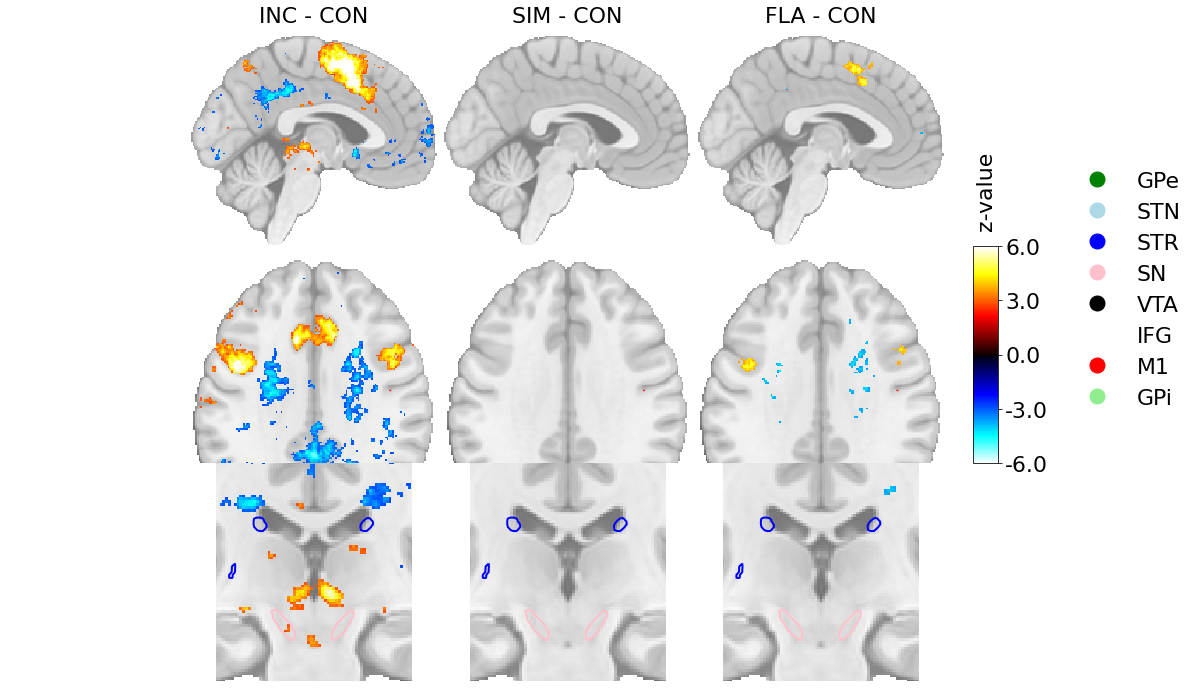

In [22]:
# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(firstmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(firstmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(firstmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(firstmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'], #'AV'
                          cut_coords=[[-3], [33], [-23]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('INC - CON')
axes[0,1].set_title('SIM - CON')
axes[0,2].set_title('FLA - CON')
# axes[0,3].set_title('INC - FLA')
# axes[0,4].set_title('INC - SIM')
# axes[0,5].set_title('SIM - FLA')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

Text(0.5, 1.0, 'z-value')

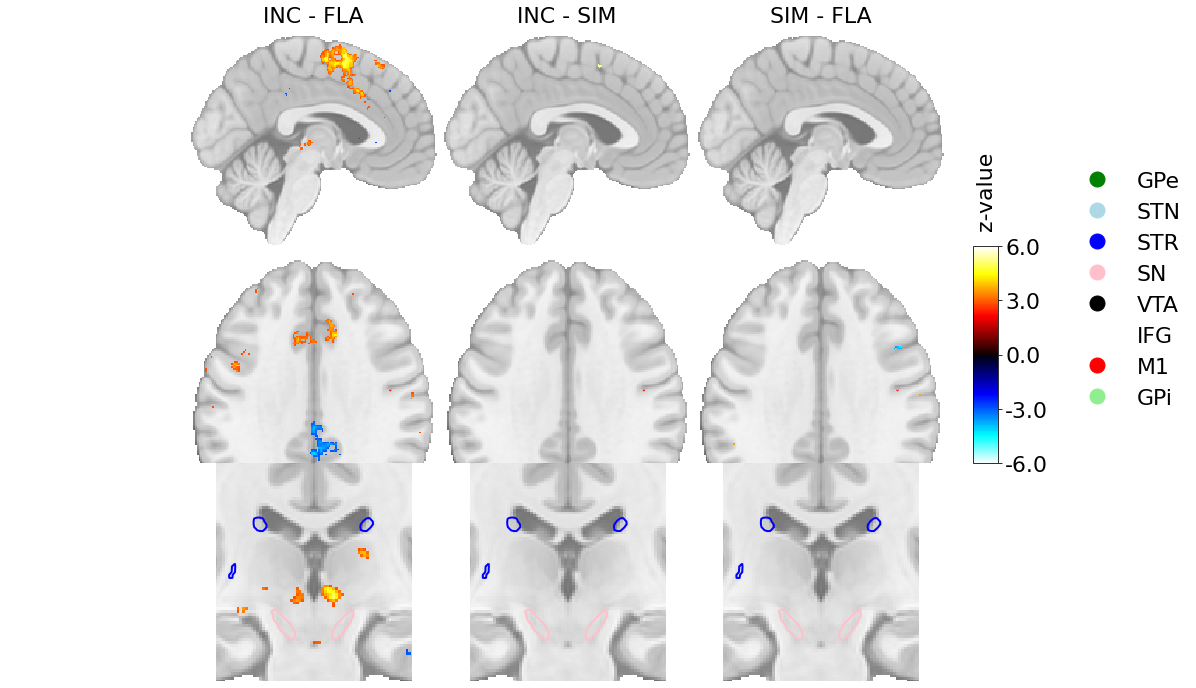

In [23]:
# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(secondmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(secondmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(secondmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(secondmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'], #'AV'
                          cut_coords=[[-3], [33], [-23]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
# axes[0,0].set_title('INC - CON')
# axes[0,1].set_title('SIM - CON')
# axes[0,2].set_title('FLA - CON')
axes[0,0].set_title('INC - FLA')
axes[0,1].set_title('INC - SIM')
axes[0,2].set_title('SIM - FLA')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

In [ ]:
ap('simon-con', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh2)
zmap_flankercon, thresh3 = get_second_level_zmap('flanker-con', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh3)
zmap_incflanker, thresh4 = get_second_level_zmap('inc-flanker', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh4)
zmap_incsimon, thresh5 = get_second_level_zmap('inc-simon', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh5)
zmap_simonflanker, thresh6 = get_second_level_zmap('simon-flanker', 'intercept', fwhm=fwhm,thresholding=thresh_method,model_n=0,from_working_dir=False, flame='12')
print(thresh6)

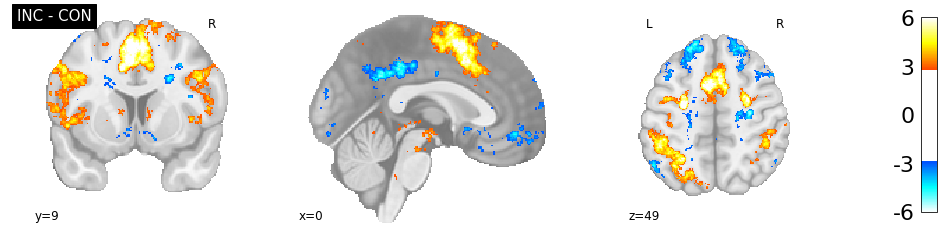

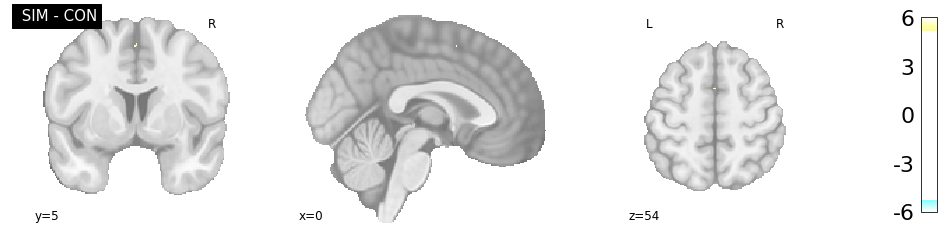

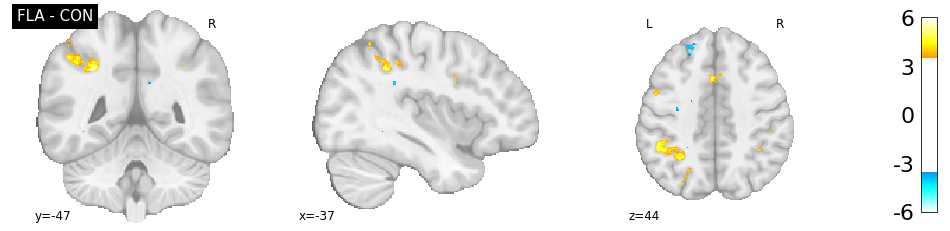

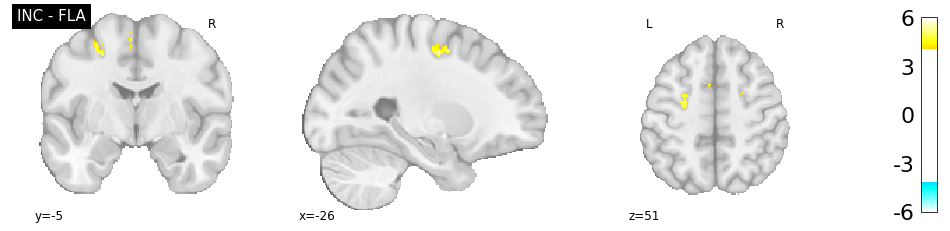

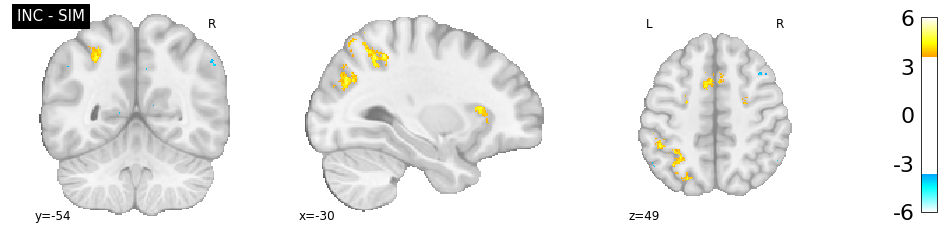

In [43]:
fig = plt.figure(figsize=(13, 3))
plotting.plot_stat_map(zmaps[0],threshold=thresh1, annotate=True,draw_cross=False,vmax=6,figure=fig, bg_img=mni09c, black_bg=False, title='INC - CON')
fig

fig1 = plt.figure(figsize=(13, 3))
plotting.plot_stat_map(zmaps[1],threshold=thresh2, annotate=True,draw_cross=False,vmax=6,figure=fig1, bg_img=mni09c, black_bg=False, title=' SIM - CON')

fig2 = plt.figure(figsize=(13, 3))
plotting.plot_stat_map(zmaps[2],threshold=thresh3, annotate=True,draw_cross=False,vmax=6,figure=fig2, bg_img=mni09c, black_bg=False, title='FLA - CON')

fig3 = plt.figure(figsize=(13, 3))
plotting.plot_stat_map(zmaps[3],threshold=thresh4, annotate=True,draw_cross=False,vmax=6,figure=fig3, bg_img=mni09c, black_bg=False, title='INC - FLA')

fig4 = plt.figure(figsize=(13, 3))
plotting.plot_stat_map(zmaps[4],threshold=thresh5, annotate=True,draw_cross=False,vmax=6,figure=fig4, bg_img=mni09c, black_bg=False, title='INC - SIM')

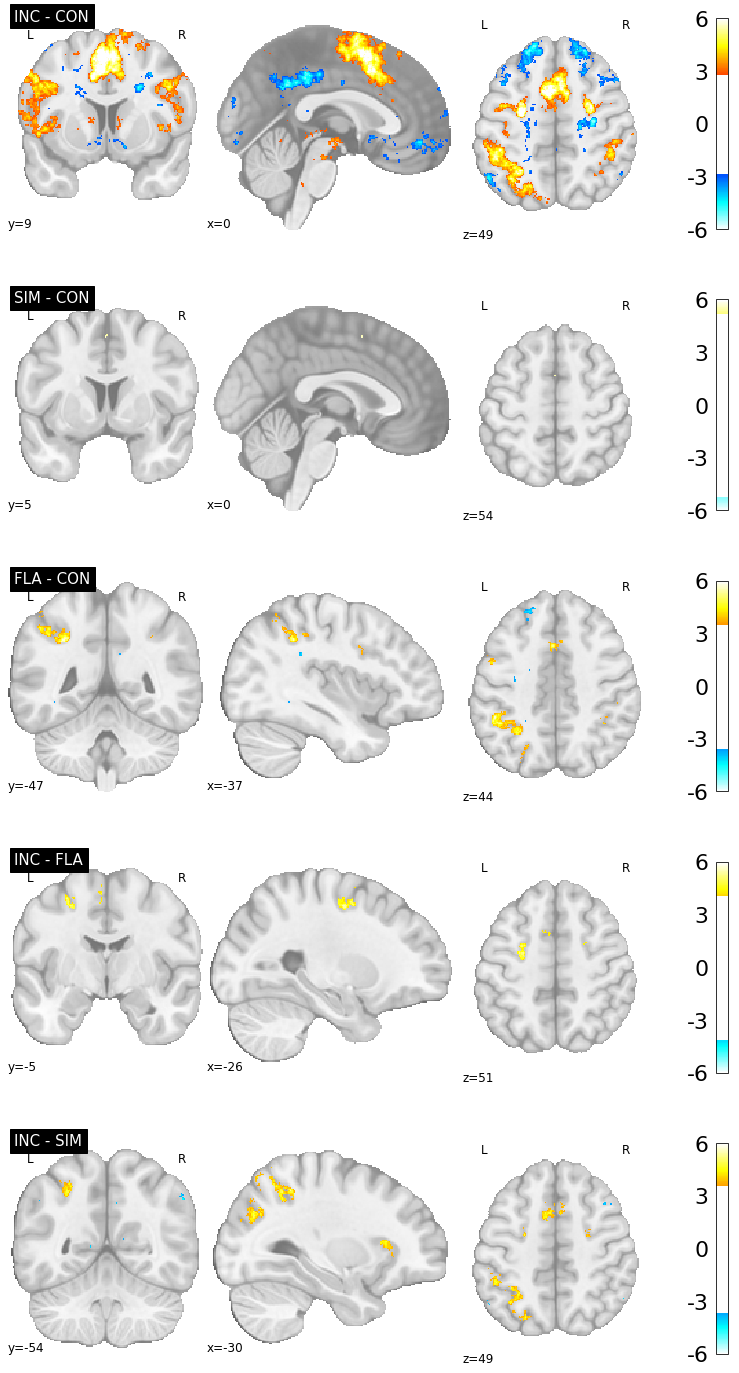

In [52]:
f, axs = plt.subplots(5,1,figsize=(13, 25))
axes = axs.ravel()

plotting.plot_stat_map(zmaps[0],threshold=thresh1, annotate=True,draw_cross=False,vmax=6,axes=axes[0], bg_img=mni09c, black_bg=False, title='INC - CON')
plotting.plot_stat_map(zmaps[1],threshold=thresh2, annotate=True,draw_cross=False,vmax=6,axes=axes[1], bg_img=mni09c, black_bg=False, title='SIM - CON')
plotting.plot_stat_map(zmaps[2],threshold=thresh3, annotate=True,draw_cross=False,vmax=6,axes=axes[2], bg_img=mni09c, black_bg=False, title='FLA - CON')
plotting.plot_stat_map(zmaps[3],threshold=thresh4, annotate=True,draw_cross=False,vmax=6,axes=axes[3], bg_img=mni09c, black_bg=False, title='INC - FLA')
plotting.plot_stat_map(zmaps[4],threshold=thresh5, annotate=True,draw_cross=False,vmax=6,axes=axes[4], bg_img=mni09c, black_bg=False, title='INC - SIM')

In [20]:
plot_rois = ['rIFG', 'M1','lSTR', 'lGPe', 'lGPi', 'lSTN', 'lVTA', 'lSN','rSTR', 'rGPe', 'rGPi', 'rSTN', 'rVTA', 'rSN']
colours = ['white','red','blue','darkgreen','lightgreen','lightblue','black','pink','blue','darkgreen','lightgreen','lightblue','black','pink']

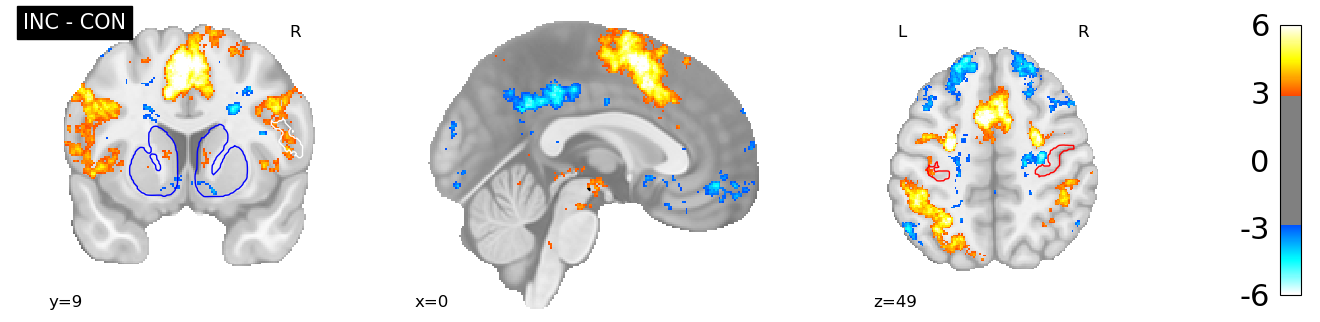

In [23]:
fig = plt.figure(figsize=(13, 3))
disp = plotting.plot_stat_map(zmaps[0],threshold=thresh1, annotate=True,draw_cross=False,vmax=6,figure=fig, bg_img=mni09c, black_bg=False, title='INC - CON')
for i, c in zip(plot_rois,colours):
    this_roi = f'/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym/space-MNI152NLin2009cAsym_label-{i}_probseg.nii.gz'
    add_contours(disp, this_roi,color=c,linewidth=1)

Text(0.5, 1.0, 'z-value')

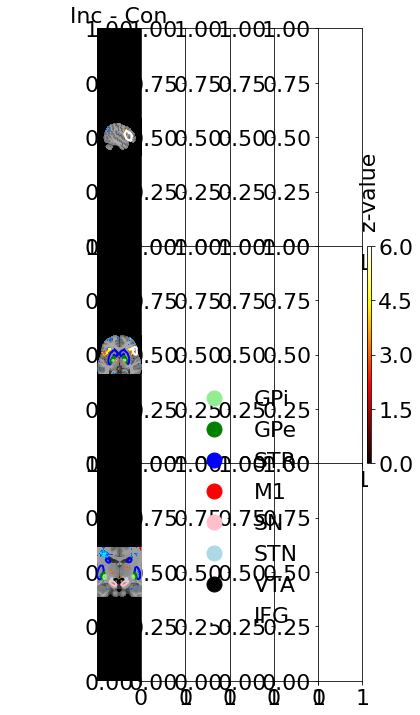

In [30]:
# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm([zmap_inccon], 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Inc - Con')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

## FWHM = 1.5

/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


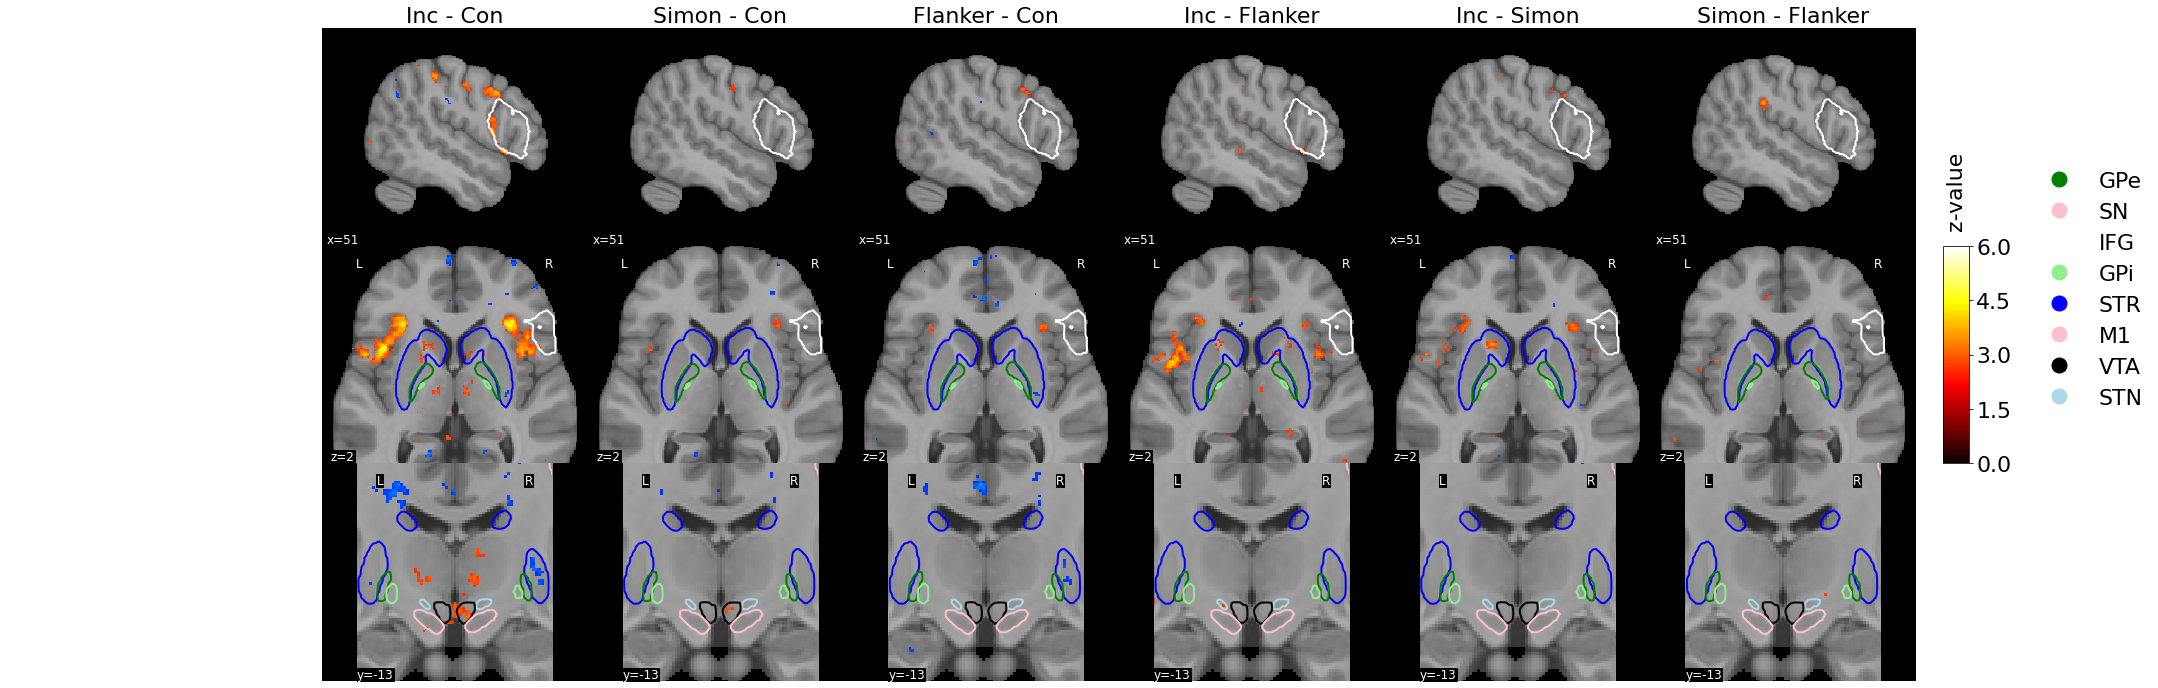

In [7]:
# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=2.6,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4, 5),
                          annotate=True, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Inc - Con')
axes[0,1].set_title('Simon - Con')
axes[0,2].set_title('Flanker - Con')
axes[0,3].set_title('Inc - Flanker')
axes[0,4].set_title('Inc - Simon')
axes[0,5].set_title('Simon - Flanker')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

## FWHM = 4.5

Text(0.5, 1.0, 'z-value')

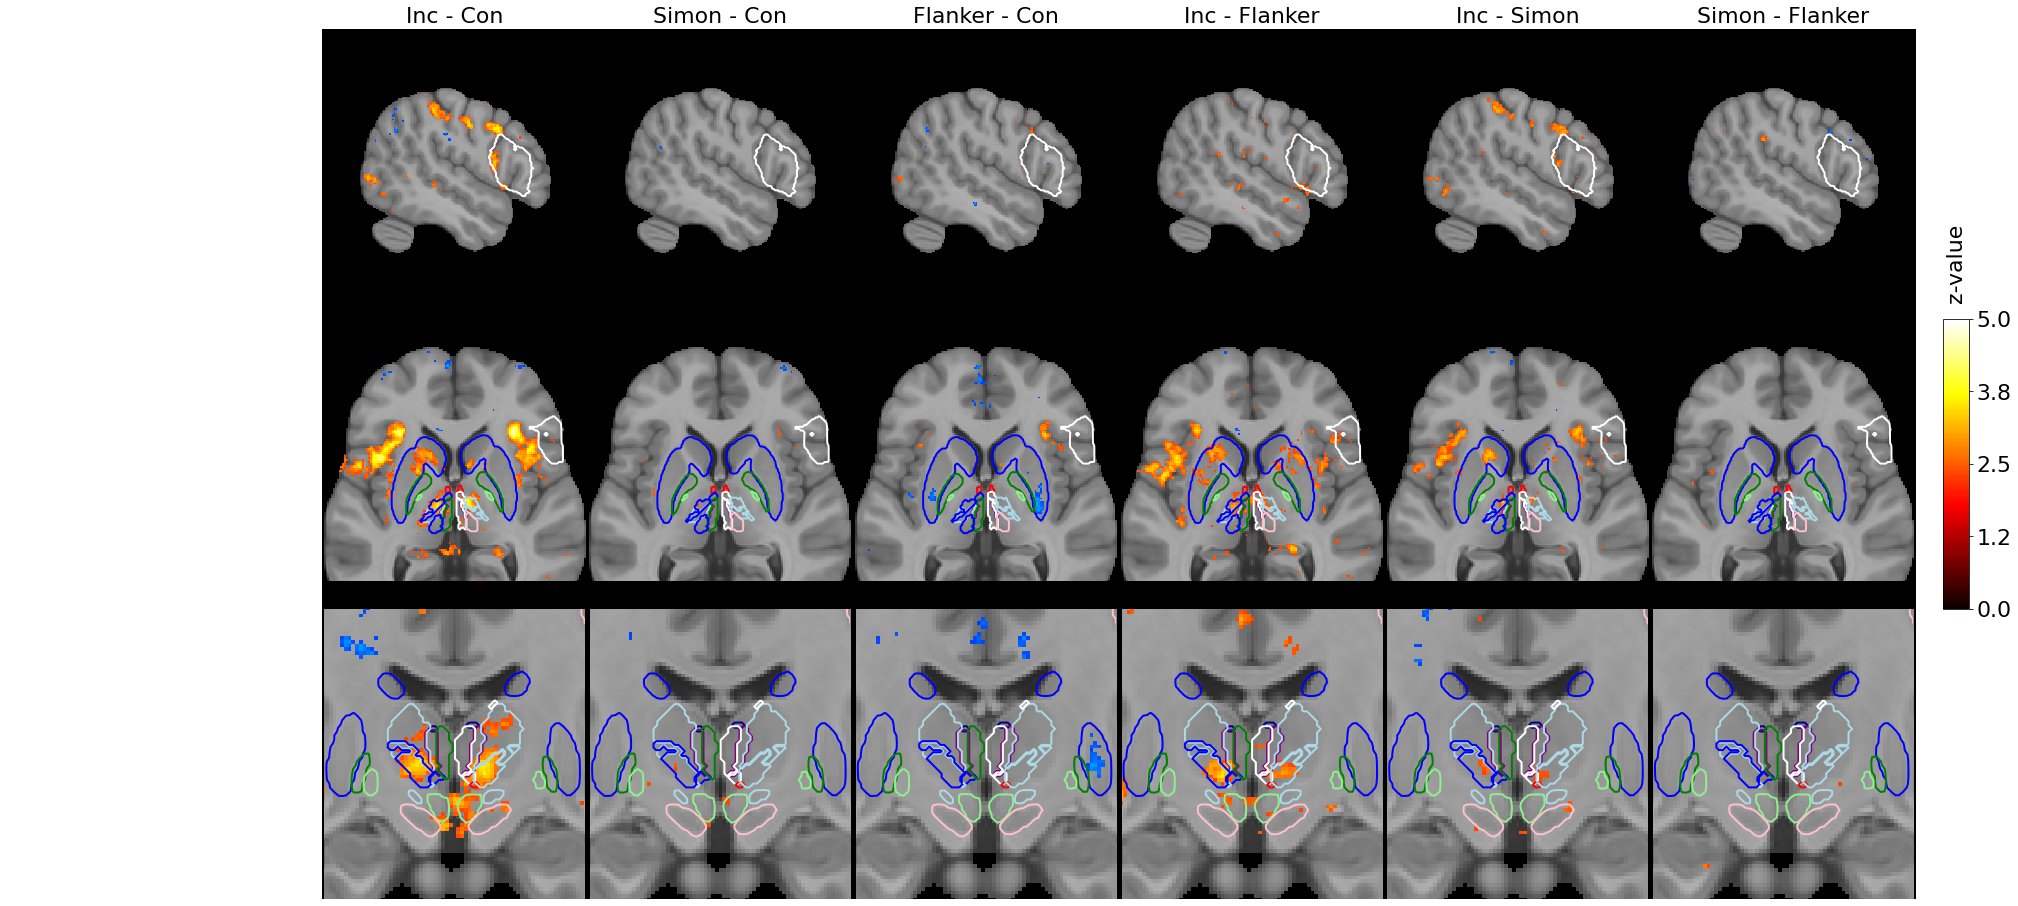

In [7]:
# plot t maps for smoothed images
fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=2.3,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN','AV'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4, 5),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Inc - Con')
axes[0,1].set_title('Simon - Con')
axes[0,2].set_title('Flanker - Con')
axes[0,3].set_title('Inc - Flanker')
axes[0,4].set_title('Inc - Simon')
axes[0,5].set_title('Simon - Flanker')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)
# plt.gcf().set_size_inches(45, 30)

### look at specific thalamic nuclei

/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:782: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


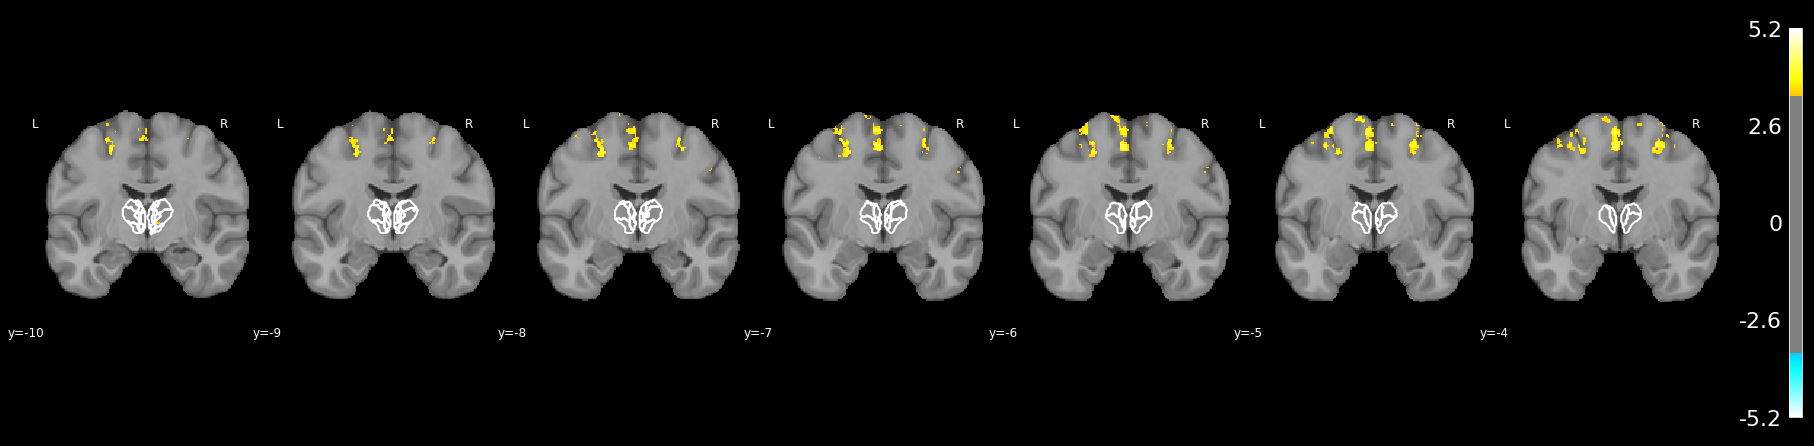

In [100]:
disp = plotting.plot_stat_map(zmap_inccon, bg_img=mni09c, 
                              threshold=3.5, cut_coords=[-10,-9,-8,-7,-6,-5,-4],
                              display_mode='y')
for i in glob.glob('../derivatives/thalamic_segmentations/mni09c/*res-1p0.nii.gz'):
#     add_contours(disp, roi='../derivatives/thalamic_segmentations/0p5mm/mni09c/mni09c_roi-AV-l_res-0p5.nii.gz', color=list(np.random.choice(range(1), size=3)))
    add_contours(disp, roi=i)
plt.gcf().set_size_inches(25,6)

/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


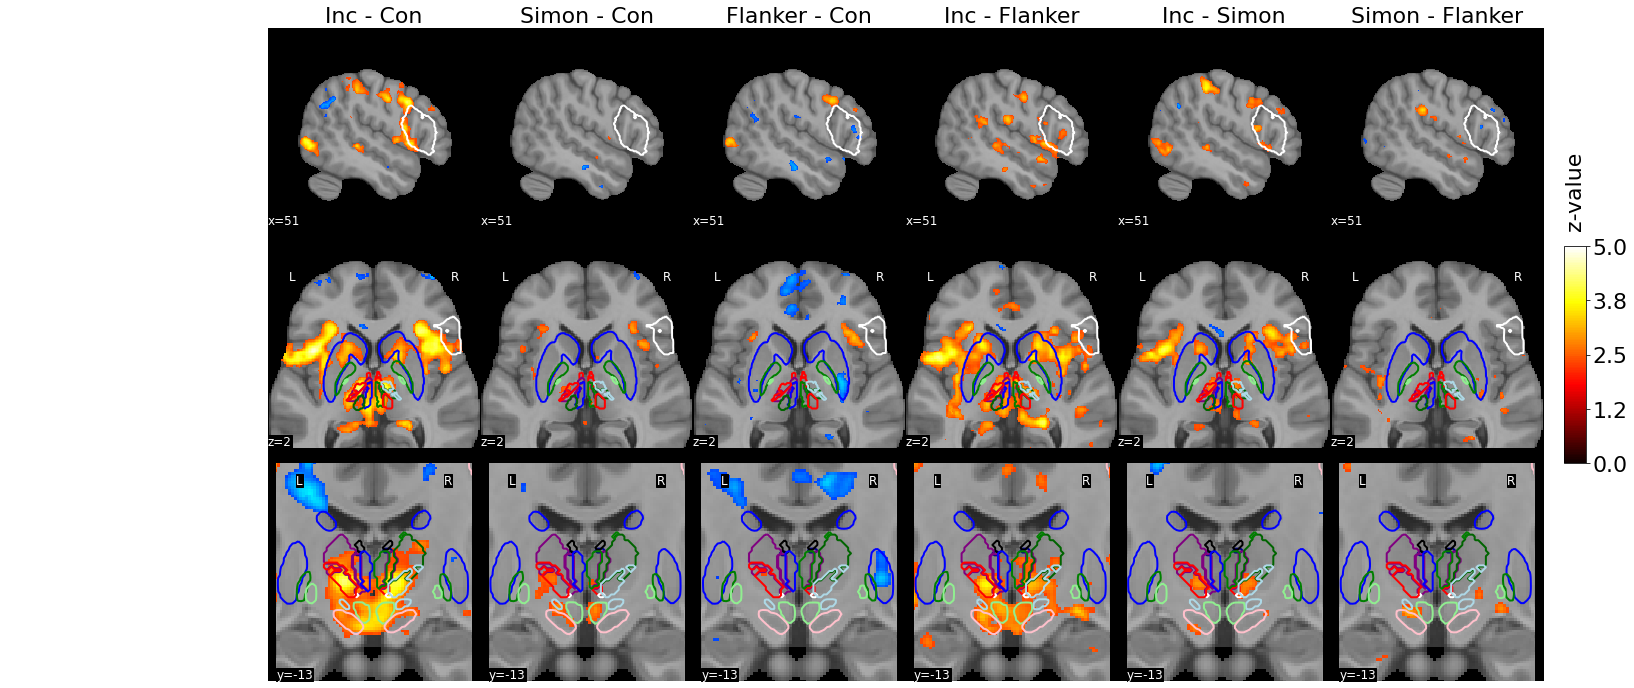

In [5]:
# plot t maps for smoothed images
fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=2.3,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4, 5),
                          annotate=True, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Inc - Con')
axes[0,1].set_title('Simon - Con')
axes[0,2].set_title('Flanker - Con')
axes[0,3].set_title('Inc - Flanker')
axes[0,4].set_title('Inc - Simon')
axes[0,5].set_title('Simon - Flanker')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

ValueError: Invalid RGBA argument: 0.35

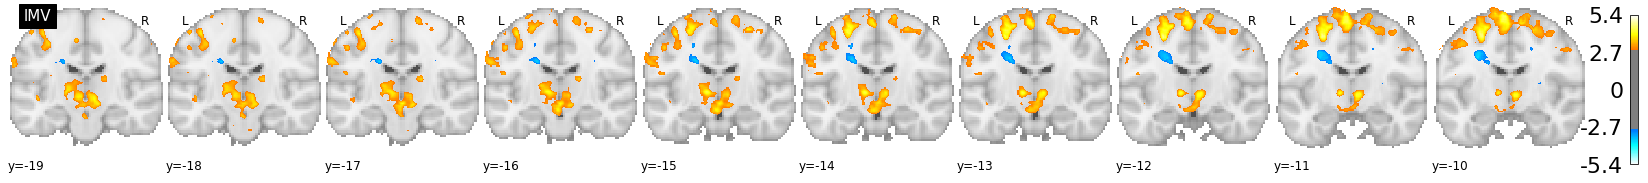

In [60]:
disp = plotting.plot_stat_map(zmaps[0],threshold=2.9,cut_coords=(-10,-11,-12,-13,-14,-15,-16,-17,-18,-19),display_mode='y',title=roi_)
roi_s = get_roi_dict()
for roi_ in structs:
    roi_map = roi_s[roi_]
#     disp = plotting.plot_stat_map(zmaps[0],threshold=2.9,cut_coords=(-10,-11,-12,-13,-14,-15,-16,-17,-18,-19),display_mode='y',title=roi_)
    add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=0.35)
    plt.gcf().set_size_inches(25,5)

In [42]:
structs = ['lMV','lVLa','lPaV','rCL','rMGN','lVLp','rPuI','lMGN','rMV','rVA','rCM','rR','lCL','rVLp','lVAmc','rCeM','rPuL','rMDm','rLSg','lPuA','rVAmc','lPt','rPuA','lCeM','lPuL','lVM','rLGN','lR','rPt','rVPL',
'lVPL','rPaV','lLGN','rMDl','lMDm','rPc','rAV','rVLa','lLSg','lLD','rPuM','lAV','lMDl','lCM','rPf','lPuI','lPf','rLP','lPuM','rLD','rVM','lVA','lLP','lPc']

# extract regions from main contrast

In [27]:
from nilearn.image import threshold_img

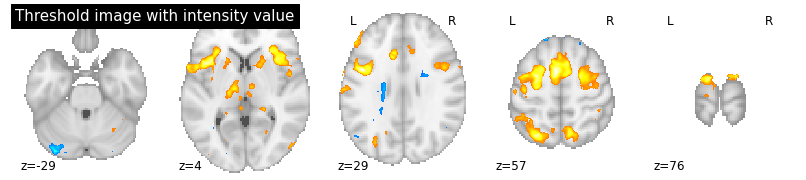

In [33]:
# thresh_method = 'fdr'
fwhm = '4p5'

zmap_inccon_unthr, thresh = get_second_level_zmap('inc-con', 'intercept', fwhm=fwhm, thresholding=None)

threshold_value_img = threshold_img(zmap_inccon_unthr, threshold=2.9, copy=False)

plotting.plot_stat_map(threshold_value_img, display_mode='z', cut_coords=5,
                       title='Threshold image with intensity value', colorbar=False)


In [34]:
from nilearn.regions import connected_regions

regions_value_img, index = connected_regions(threshold_value_img,
                                             min_region_size=1500)

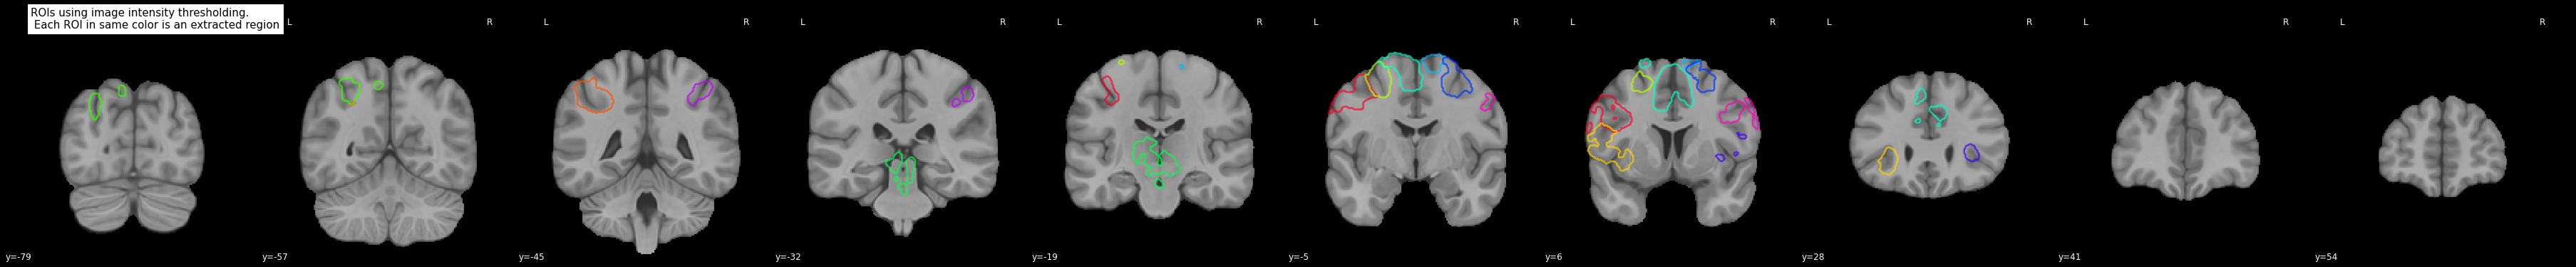

In [47]:
title = ("ROIs using image intensity thresholding. "
         "\n Each ROI in same color is an extracted region")
plotting.plot_prob_atlas(regions_value_img, bg_img=mni09c,#bg_img=zmap_inccon_unthr,
                         view_type='contours', display_mode='y',
                         cut_coords=10, title=title)
plt.gcf().set_size_inches(50,10)
plotting.show()


In [49]:
zmap_inccon_unthr.to_filename('/home/scotti/temp_inc_con_zstat.nii.gz')

In [14]:
from templateflow.api import get

In [20]:
# import harvard xford prob atlas in mni09c
# from templateflow.api import get
# [f.name for f in get('MNI152NLin2009cAsym', resolution='01', atlas="HO.*")]                                                             
# get('MNI152NLin2009cAsym', resolution=1, desc='th0', suffix='HOCPAL', extension='nii.gz')

[]

In [29]:
lol

{'GPe': 'green',
 'GPi': 'lightgreen',
 'STR': 'blue',
 'PreSMA': 'darkgreen',
 'ACC': 'green',
 'M1': 'pink',
 'STN': 'lightblue',
 'rIFG': 'white'}

In [25]:
lol.keys()

dict_keys(['GPe', 'GPi', 'STR', 'PreSMA', 'ACC', 'M1', 'STN', 'rIFG'])

In [53]:
from matplotlib.lines import Line2D

custom_lines = []
keys = list(lol.keys())
values = list(lol.values())
for i, val in enumerate(values):
    
    custom_lines.append(Line2D([0], [0], marker='o', linestyle='None', markersize=15,color=val))
    
# custom_lines = [Line2D([0], [0], marker='o', linestyle='None', markersize=15,color=list(lol.values())[0], lw=4),
#                 Line2D([0], [0], marker='o', linestyle='None', markersize=15,color=list(lol.values())[1], lw=4),
#                 Line2D([0], [0], marker='o', linestyle='None', markersize=15,color=list(lol.values())[2], lw=4)]

# fig, ax = plt.subplots()
# lines = ax.plot(data)
# ax.legend(custom_lines, ['Cold', 'Medium', 'Hot'])

In [55]:
custom_lines

In [36]:
list(lol.values())[:3]

['green', 'lightgreen', 'blue']

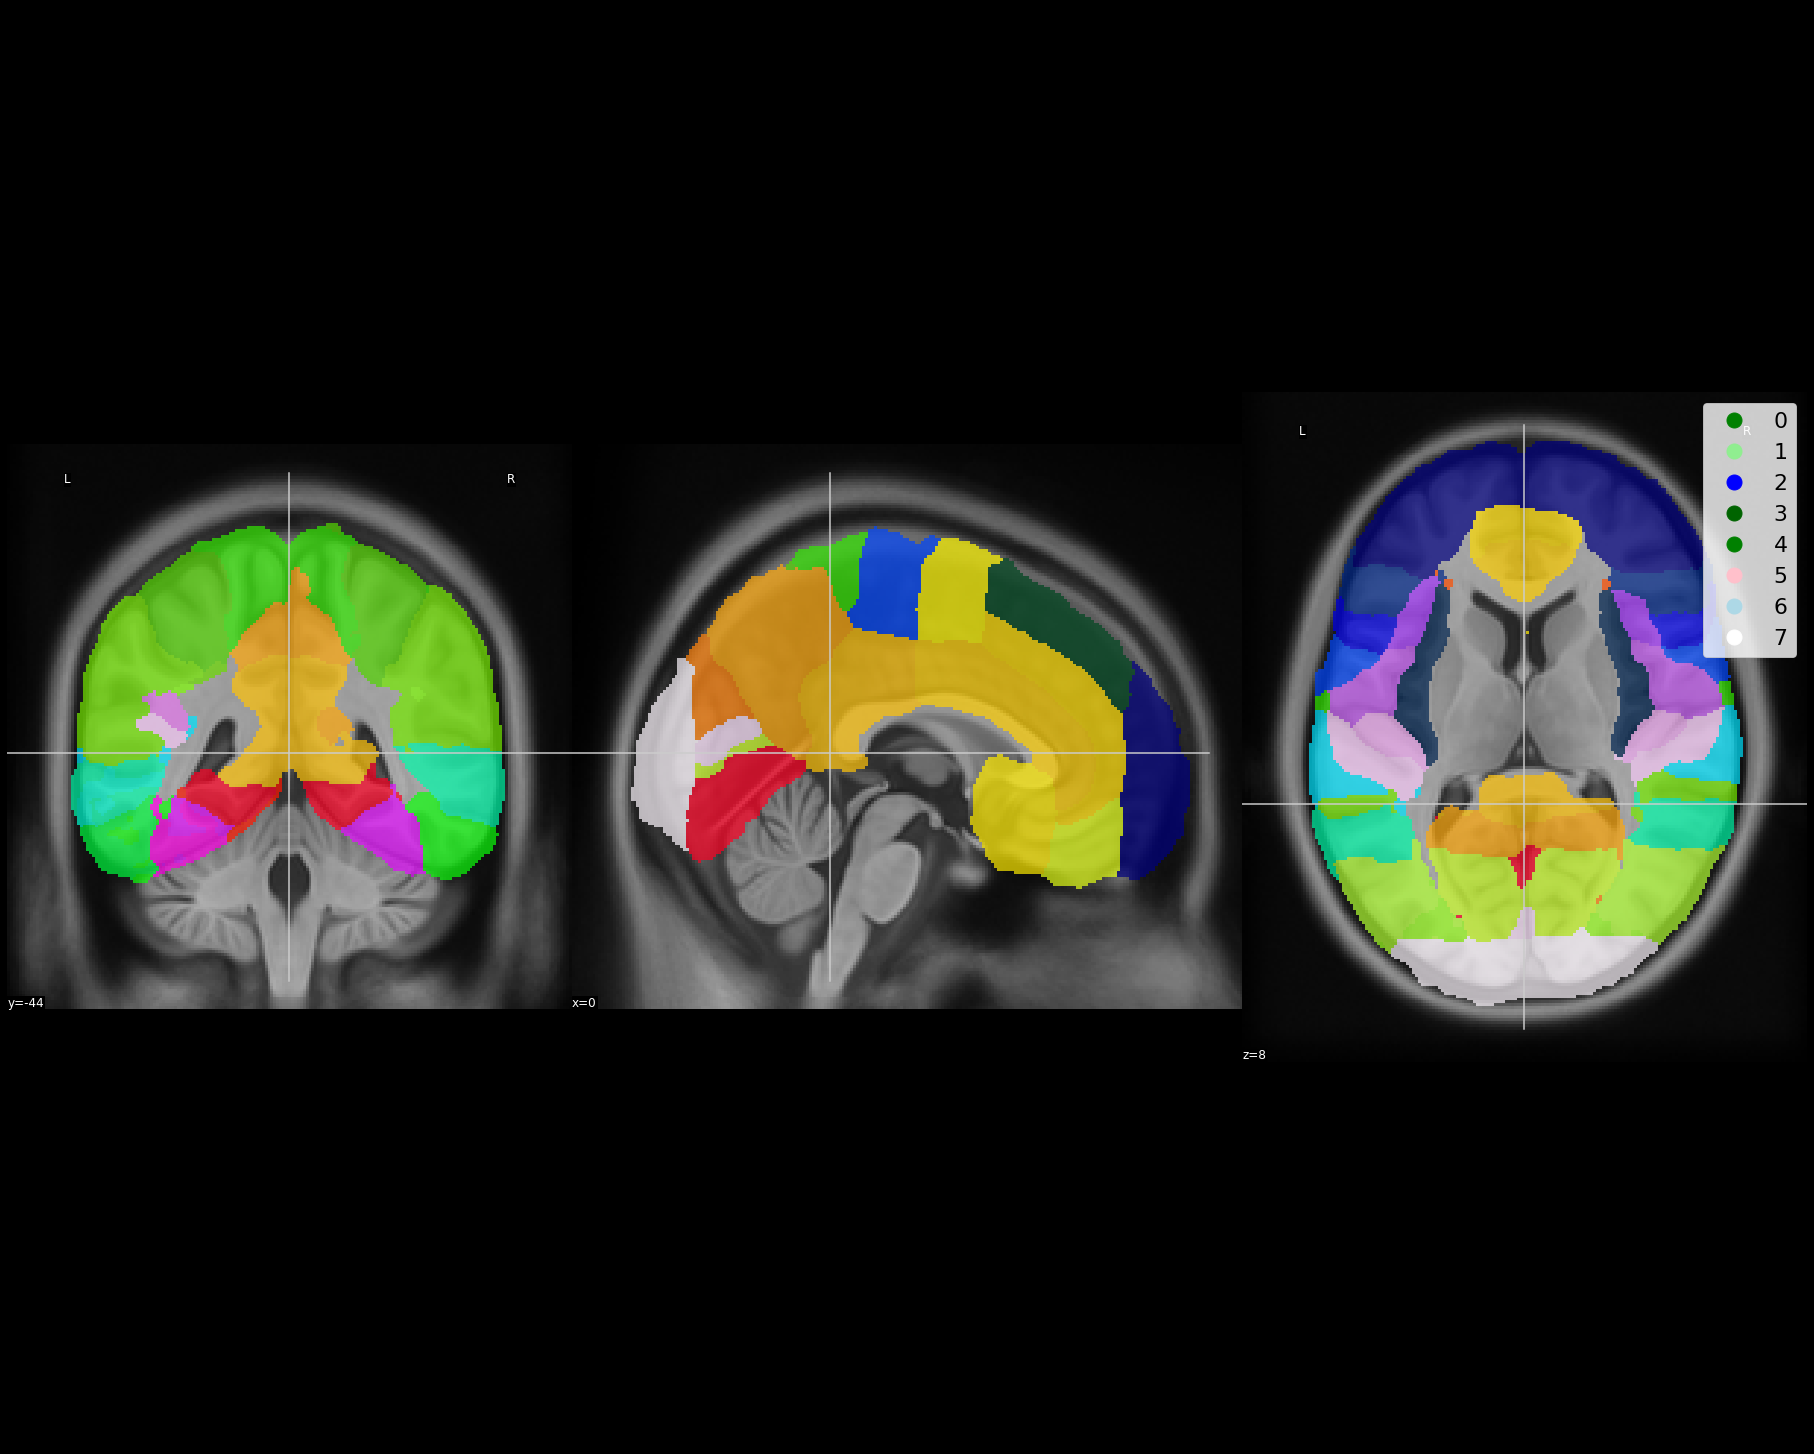

In [56]:
# use harvard-oxford cortical masks, ew gross i know
atlas = '/usr/local/fsl/6.0/data/atlases/HarvardOxford/HarvardOxford-cort-prob-1mm.nii.gz'
atlas = '/home/scotti/tpl-MNI152NLin2009cAsym_res-01_atlas-HOCPA_desc-th0_dseg.nii.gz'
mni_ = '/home/scotti/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz'
plotting.plot_roi(atlas, bg_img = mni_)
# plt.legend(labels= list(lol.keys())[:3], handles=custom_lines)
plt.legend(labels= [0,1,2,3,4,5,6,7], handles=custom_lines)
plt.gcf().set_size_inches(25,20)

# RANDOM

In [7]:
roi_to_plot=['PreSMA', 'M1', 'ACC', 'rIFG', 'STR', 'GPe', 'GPi', 'STN','STN']

def get_color(mask):
    import numpy as np
    if 'STN' in mask:
        return 'lightblue'
    if 'STR' in mask:
        return 'blue'
    if 'PreSMA' in mask:
        return 'darkgreen'
    if 'ACC' in mask:
        return 'green'
    if 'M1' in mask:
        return 'pink'
    if 'GPi' in mask:
        return 'lightgreen'
    if 'GPe' in mask:
        return 'green'
    if 'IFG' in mask:
        return 'white'
    if 'VTA' in mask:
        return 'lightgreen'
    if 'SN' in mask:
        return 'pink'
    if 'AV' in mask:
        return 'red'
    if 'CL' in mask:
        return 'darkblue'
    if 'LGN' in mask:
        return 'yellow'
    if 'MDl' in mask:
        return 'purple'
    if 'Pf' in mask:
        return 'brown'
    else:
        return np.random.choice(['lightblue','blue','darkgreen','green','pink','purple','red','white'])

In [8]:
lol = dict([(x, get_color(x)) for x in list(set(roi_to_plot))])

In [13]:
col_labels = dict([(x, get_color(x)) for x in list(set(roi_to_plot))])


In [11]:
roi_to_plot = list(set(roi_to_plot))

In [15]:
lol = [s.replace('l','') for s in [x.replace('r','') for x in roi_to_plot]]

In [16]:
lol

['GPe', 'GPi', 'IFG', 'M1', 'PeSMA', 'STN', 'ACC', 'STR']

In [23]:
list(roi_to_plot)

['PreSMA',
 'M1',
 'ACC',
 'rIFG',
 'STR',
 'GPe',
 'GPi',
 'STN',
 'STN',
 ['PreSMA', 'M1', 'ACC', 'rIFG', 'STR', 'GPe', 'GPi', 'STN', 'STN', [...]]]

In [25]:
renam = glob.glob('../sourcedata/masks/mni_and_thal/*1p0*')

for i in renam:
    new = i.replace('_res-1p0','_probseg')
    if '-r' in new:
        new = new.replace('-r','').replace('mni09c_roi-','space-MNI152NLin2009cAsym_label-r')
    elif '-l' in new:
        new = new.replace('-l','').replace('mni09c_roi-','space-MNI152NLin2009cAsym_label-l')
    print(new)    
    shutil.move(i,new)

../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lMV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lVLa_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPaV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rCL_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rMGN_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lVLp_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPuI_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lMGN_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rMV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rVA_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rCM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rR_pr

In [8]:
def get__dict():
    # make dict of masks & filenames in 09c-space, get colors
    fns = glob.glob('../sourcedata/masks/mni_and_thal/space*')
    fns.sort()
    names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_label-(?P<label>[a-zA-Z0-9]+)_probseg.nii.gz', fn).groupdict()['label'] for fn in fns]
    roi_dict = dict(zip(names, fns))
    for mask, fn in roi_dict.items():
        roi_dict[mask] = {}
        roi_dict[mask]['fn'] = fn
        roi_dict[mask]['color'] = get_color(mask)
        roi_dict[mask]['threshold'] = 0.3
    return roi_dict

lol = get__dict()

In [32]:
lol="""
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lMV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lVLa_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPaV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rCL_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rMGN_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lVLp_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPuI_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lMGN_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rMV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rVA_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rCM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rR_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lCL_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rVLp_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lVAmc_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rCeM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPuL_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rMDm_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rLSg_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPuA_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rVAmc_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPt_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPuA_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lCeM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPuL_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lVM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rLGN_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lR_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPt_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rVPL_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lVPL_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPaV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lLGN_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rMDl_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lMDm_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPc_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rAV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rVLa_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lLSg_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lLD_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPuM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lAV_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lMDl_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lCM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rPf_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPuI_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPf_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rLP_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPuM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rLD_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-rVM_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lVA_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lLP_probseg.nii.gz
../sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-lPc_probseg.nii.gz"""

In [34]:
lol = lol.replace('_probseg.nii.gz',',')

In [36]:
lol = lol.replace('/sourcedata/masks/mni_and_thal/space-MNI152NLin2009cAsym_label-','')

In [38]:
lol = lol.replace('\n..','')

In [40]:
lol = lol.replace(",","','")

In [41]:
lol

"lMV','lVLa','lPaV','rCL','rMGN','lVLp','rPuI','lMGN','rMV','rVA','rCM','rR','lCL','rVLp','lVAmc','rCeM','rPuL','rMDm','rLSg','lPuA','rVAmc','lPt','rPuA','lCeM','lPuL','lVM','rLGN','lR','rPt','rVPL','lVPL','rPaV','lLGN','rMDl','lMDm','rPc','rAV','rVLa','lLSg','lLD','rPuM','lAV','lMDl','lCM','rPf','lPuI','lPf','rLP','lPuM','rLD','rVM','lVA','lLP','lPc','"

In [56]:
lol = glob.glob('/home/Public/trondheim/derivatives/bids/sub-036/ses-rlsat/anat/*')

for i in lol:
    new = i.replace('sstmsit','rlsat')
    print(new)
    shutil.move(i,new)

/home/Public/trondheim/derivatives/bids/sub-036/ses-rlsat/anat/sub-036_ses-rlsat_inv-1_mprage.nii.gz
/home/Public/trondheim/derivatives/bids/sub-036/ses-rlsat/anat/sub-036_ses-rlsat_T1w.nii.gz
/home/Public/trondheim/derivatives/bids/sub-036/ses-rlsat/anat/sub-036_ses-rlsat_inv-1_mprage.json
/home/Public/trondheim/derivatives/bids/sub-036/ses-rlsat/anat/sub-036_ses-rlsat_T1w.json
/home/Public/trondheim/derivatives/bids/sub-036/ses-rlsat/anat/sub-036_ses-rlsat_inv-2_mprage.nii.gz
/home/Public/trondheim/derivatives/bids/sub-036/ses-rlsat/anat/sub-036_ses-rlsat_inv-2_mprage.json


In [53]:
import shutil

In [6]:
zmaps=[nib.load('../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_3_fwhm_1p5_model_n_0/zstat1.nii.gz'),
nib.load('../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_5_fwhm_1p5_model_n_0/zstat1.nii.gz'),
nib.load('../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_4_fwhm_1p5_model_n_0/zstat1.nii.gz'),
nib.load('../derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/third_level_model/level3_zstats/_contrast_n_6_fwhm_1p5_model_n_0/zstat1.nii.gz'),
nib.load('/home/scotti/test_nilearn_conj/min/fwhm-1p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz')]

Text(0.5, 1.0, 'z-value')

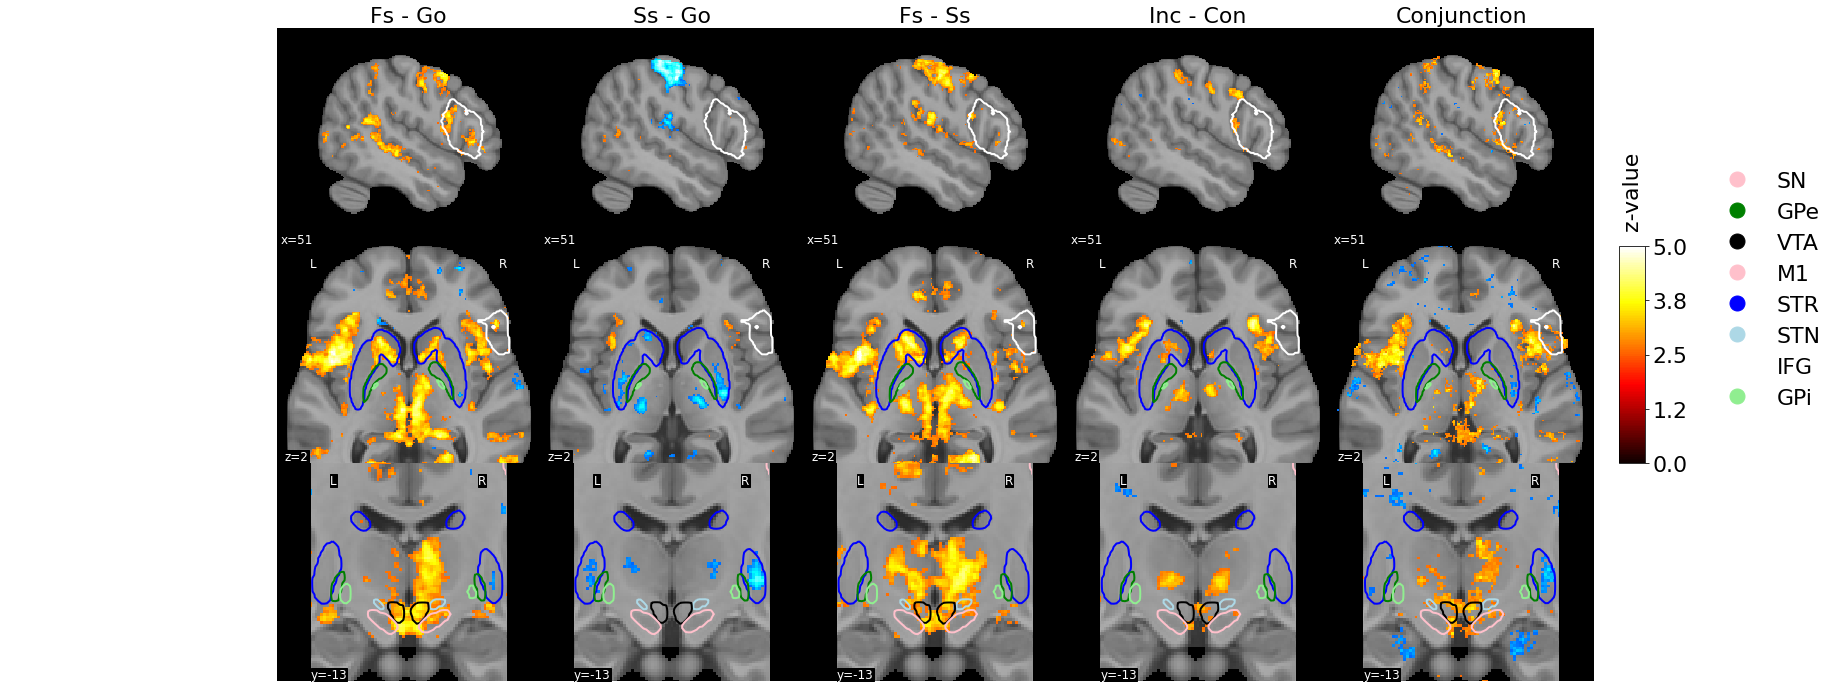

In [7]:
# plot t maps for smoothed images
fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=2.6,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=True, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Fs - Go')
axes[0,1].set_title('Ss - Go')
axes[0,2].set_title('Fs - Ss')
axes[0,3].set_title('Inc - Con')
axes[0,4].set_title('Conjunction')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)